# PyTorch MNIST Classifier

In this notebook I will implement a deep convolutional neural network to classify handwritten digits from the MNIST dataset.

Import all the necessary packages:

In [19]:
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [20]:
device = torch.device(
    'cuda' 
    if torch.cuda.is_available() 
    else 'cpu'
)

Define the validation, train, and test subsets:

In [21]:
image_path = './'
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=False
)

#  mnist_dataset.data = mnist_dataset.data.to(device=device)
#  mnist_dataset.targets = mnist_dataset.targets.to(device=device)

mnist_valid_dataset = Subset(
    mnist_dataset,
    torch.arange(10_000)
)

mnist_train_dataset = Subset(
    mnist_dataset,
    torch.arange(
        10_000, len(mnist_dataset) 
    )
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=False,
    transform=transform,
    download=False
)

Set up data loaders:

In [22]:
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(
    mnist_train_dataset,
    batch_size,
    shuffle=True
)

valid_dl = DataLoader(
    mnist_valid_dataset,
    batch_size,
    shuffle=False
)

In [23]:
my_net = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(3136, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 10)
)

In [24]:
my_net.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=1024, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=1024, out_features=10, bias=True)
)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3)

In [26]:
def train(model, n_epochs, train_dl, valid_dl):
    loss_history_train = [0] * n_epochs
    loss_history_valid = [0] * n_epochs
    accuracy_history_train = [0] * n_epochs
    accuracy_history_valid = [0] * n_epochs

    for epoch in range(n_epochs):
        model.train()

        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            prediction = model(x_batch)
            loss_value = loss_fn(prediction, y_batch)
            loss_value.backward()
            optimizer.step()

            loss_history_train[epoch] += loss_value.item() * y_batch.size(0)

            is_correct = (
                torch.argmax(prediction, dim=1) == y_batch
            ).float().cpu()

            accuracy_history_train[epoch] += is_correct.sum()
        
        loss_history_train[epoch] /= len(train_dl.dataset)
        accuracy_history_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                prediction = model(x_batch)
                loss_value = loss_fn(prediction, y_batch)

                loss_history_valid[epoch] += loss_value.item() * y_batch.size(0)

                is_correct = (
                    torch.argmax(prediction, dim=1) == y_batch
                ).float().cpu()

                accuracy_history_valid[epoch] += is_correct.sum()
        loss_history_valid[epoch] /= len(valid_dl.dataset)
        accuracy_history_valid[epoch] /= len(valid_dl.dataset)

        print(
            f'Epoch {epoch + 1} '
            f'train accuracy: {accuracy_history_train[epoch]:.3f} '
            f'validation accuracy: {accuracy_history_valid[epoch]:.3f}'
        )

    return loss_history_train, loss_history_valid,\
           accuracy_history_train, accuracy_history_valid 

In [27]:
n_epochs = 20
hist = train(my_net, n_epochs, train_dl, valid_dl)

Epoch 1 train accuracy: 0.948 validation accuracy: 0.982
Epoch 2 train accuracy: 0.984 validation accuracy: 0.986
Epoch 3 train accuracy: 0.989 validation accuracy: 0.984
Epoch 4 train accuracy: 0.992 validation accuracy: 0.989
Epoch 5 train accuracy: 0.993 validation accuracy: 0.989
Epoch 6 train accuracy: 0.994 validation accuracy: 0.985
Epoch 7 train accuracy: 0.995 validation accuracy: 0.989
Epoch 8 train accuracy: 0.996 validation accuracy: 0.988
Epoch 9 train accuracy: 0.996 validation accuracy: 0.990
Epoch 10 train accuracy: 0.996 validation accuracy: 0.991
Epoch 11 train accuracy: 0.997 validation accuracy: 0.990
Epoch 12 train accuracy: 0.997 validation accuracy: 0.990
Epoch 13 train accuracy: 0.998 validation accuracy: 0.990
Epoch 14 train accuracy: 0.998 validation accuracy: 0.991
Epoch 15 train accuracy: 0.998 validation accuracy: 0.991
Epoch 16 train accuracy: 0.998 validation accuracy: 0.990
Epoch 17 train accuracy: 0.998 validation accuracy: 0.989
Epoch 18 train accuracy

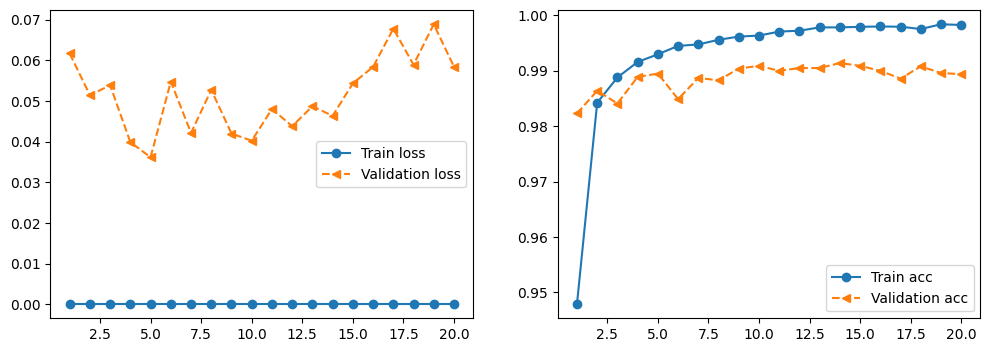

In [31]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc')
ax.plot(x_arr, hist[3], '--<', label='Validation acc')
ax.legend()
plt.show()

In [29]:
type(hist[2][0])

torch.Tensor